torch.Size([1, 256, 256])
input_texture torch.Size([1, 256, 256])
prep_std 1.2960850304198857
input_torch torch.Size([1, 3, 256, 256])
save to pdf file ./results_vgg_model_gray_size256/tur2a_im0


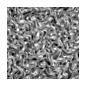

In [5]:
# use L-BFGS on Gatys's VGG texture model
#  (gray scale image input, with zero mean)

import sys
import datetime
from shutil import copyfile
import numpy as np
import scipy.io as sio
import math
from PIL import Image
import skimage.transform as sk
#from tqdm import tqdm
from tqdm.notebook import tqdm # trange
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
#from torch.autograd import Variable
import torchvision
from torchvision import transforms
from utils_arch import VGG
from utils_loss import GramMatrix, GramMSELoss
from utils_plot import save2pdf_gray

dataname = 'tur2a'
img_size = 256

gpu = True

# load images
#input_texture = Image.open('../images/' + input_name)
if dataname == 'tur2a':
    im_id = 0 # id of input in mat
    data = sio.loadmat('../turbulence/ns_randn4_train_N' + str(img_size) + '.mat')
    n_input_ch = 1
    input_name = 'tur2a_im0'
else:
    assert(false)

im = data['imgs'][:,:,im_id]
vmin = np.quantile(im,0.01) # for plot
vmax = np.quantile(im,0.99)
im_ori = torch.tensor(im, dtype=torch.float).unsqueeze(0) # torch (1,h,w)
if gpu:
    im_ori = im_ori.cuda()
print(im_ori.shape)

input_texture = im_ori.contiguous() # -> torch (1,h,w)
print('input_texture',input_texture.shape)

prep_std = 1/np.std(im)
print('prep_std',prep_std)
def prep(x):
    # x is in torch (1,h,w)
    # xc in in torch (3,h,w)    
#     xc = torch.cat((x,x,x),dim=0) # OR 
    xc = x.expand(3,img_size,img_size)
    xc = xc / prep_std
    xc = xc * 255.0
    return xc
    
input_torch = prep(input_texture).unsqueeze(0) # torch (1,3,h,w)
print('input_torch',input_torch.shape)
if gpu == True:
    input_torch = input_torch.cuda()

# output dir
root='./results_vgg_model_gray' + '_size' + str(img_size)
#root='./results_vgg_model/'
input_pdf_name = root+'/'+input_name
input_im = input_texture[0,:,:].cpu().numpy() # (h,w)
#save2mat_gray(input_pdf_name,input_im)
save2pdf_gray(input_pdf_name,input_im,vmin=vmin,vmax=vmax)

In [9]:
# VGG model
vgg = VGG(pool='avg', pad=1)
noramlized_model = torch.load('../vgg_color_caffe/Models/vgg_normalised.caffemodel.pt')
# fix size of bias
for key,value in noramlized_model.items():
    if key.endswith('.bias'):
        noramlized_model[key] = value.view(-1)
vgg.load_state_dict(noramlized_model)
for param in vgg.parameters():
    param.requires_grad_(False) # param.requires_grad = False    

if gpu == True:
    vgg.cuda()

loss_layers = ['p4', 'p3', 'p2', 'p1', 'r11']
# w = [1e9,1e9,1e9,1e9,1e9]
w = [1e1]* len(loss_layers)
loss_fns = [GramMSELoss()] * len(loss_layers)
if gpu == True:
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

outs = vgg(input_torch, loss_layers)
target_gram_matrix = [GramMatrix()(f).detach() for f in outs]
targets = target_gram_matrix

In [10]:
# Init input image
synth = torch.randn_like(input_texture) # (1,h,w)
synth = synth.div(prep_std) # * std, estimated from input original image
if gpu == True:
    synth = synth.cuda()
synth.requires_grad_(True)

def do_synthesis(x,maxite,maxcor,gtol,ftol):
    time0 = time()
    maxeval = int(1.25*maxite)
    optimizer = optim.LBFGS({x}, max_iter=maxite, max_eval=maxeval, line_search_fn='strong_wolfe',\
                            tolerance_grad = gtol, tolerance_change = ftol,\
                            history_size = maxcor)
    
    def closure():
        optimizer.zero_grad()
        #print('x',x.shape)
        xc = prep(x).unsqueeze(0) # (1,h,w) to (1,3,h,w)
        #print('xc',xc.shape)
        out = vgg(xc, loss_layers)
        losses = [w[a]*loss_fns[a](f, targets[a])/4.0 for a,f in enumerate(out)]
        loss = sum(losses)
        #print('loss',loss)
        loss.backward()
        pbar.update(1)
        return loss
    
    pbar = tqdm(total = maxeval)
    optimizer.step(closure)
    opt_state = optimizer.state[optimizer._params[0]]
    #print(opt_state)
    niter = opt_state['n_iter']
    final_loss = opt_state['prev_loss']
    print('OPT fini avec:', final_loss, niter,'in',time()-time0,'sec')
    
    pbar.close()

do_synthesis(synth,2000,20,0.0,0.0)

OPT fini avec: 0.39872750639915466 2000 in 49.82521057128906 sec



save to pdf file ./results_vgg_model_gray_size256/tur2a_im0_vgg_nohist


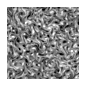

In [11]:
# post-processing
texture_synthesis = synth.detach() # .clone()
texture_synthesis = texture_synthesis.cpu().squeeze() # (h,w)

syn_pdf_name = root+'/'+input_name+'_vgg_nohist'
syn_im = texture_synthesis.numpy()
save2pdf_gray(syn_pdf_name,syn_im,vmin=vmin,vmax=vmax)
